## SciPy's `solve_ivp` (For Comparison)
As of CyRK v0.11.0, on a mid-tier desktop the following timings were found:

- SciPy.solve_ivp : 39.300  ms
- CyRK.nbsolve_ivp:  0.333  ms
- CyRK.pysolve_ivp:  1.190  ms
- CyRK.cysolve_ivp:  0.107  ms

In [1]:
import CyRK
print("CyRK Version:", CyRK.__version__)

CyRK Version: 0.12.0


Was Integration was successful? True
The solver successfully reached the end of the integration interval.


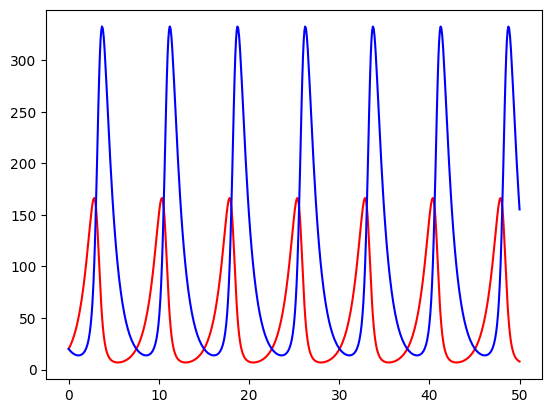

In [2]:
def diffeq(t, y):
    dy = np.empty_like(y)
    dy[0] = (1. - 0.01 * y[1]) * y[0]
    dy[1] = (0.02 * y[0] - 1.) * y[1]
    return dy

import numpy as np
from scipy.integrate import solve_ivp

initial_conds = np.asarray((20., 20.), dtype=np.float64, order='C')
time_span = (0., 50.)
rtol = 1.0e-7
atol = 1.0e-8

result = \
    solve_ivp(diffeq, time_span, initial_conds, method='RK45', rtol=rtol, atol=atol)

print("Was Integration was successful?", result.success)
print(result.message)
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(result.t, result.y[0], c='r')
ax.plot(result.t, result.y[1], c='b')
plt.show()

In [3]:
%timeit solve_ivp(diffeq, time_span, initial_conds, method='RK45', rtol=rtol, atol=atol)

37 ms ± 324 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## `nbsolve_ivp` Example

Was Integration was successful? True
Integration completed without issue.
Size of solution:  360


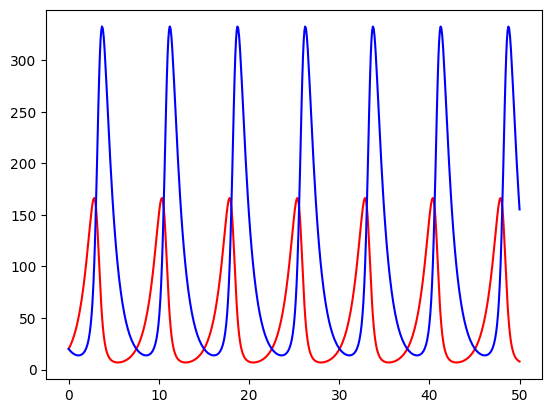

In [4]:
from numba import njit
@njit
def diffeq_nb(t, y):
    dy = np.empty_like(y)
    dy[0] = (1. - 0.01 * y[1]) * y[0]
    dy[1] = (0.02 * y[0] - 1.) * y[1]
    return dy

import numpy as np
from CyRK import nbsolve_ivp

initial_conds = np.asarray((20., 20.), dtype=np.float64, order='C')
time_span = (0., 50.)
rtol = 1.0e-7
atol = 1.0e-8

result = \
    nbsolve_ivp(diffeq_nb, time_span, initial_conds, rk_method=1, rtol=rtol, atol=atol)

print("Was Integration was successful?", result.success)
print(result.message)
print("Size of solution: ", result.size)
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(result.t, result.y[0], c='r')
ax.plot(result.t, result.y[1], c='b')
plt.show()

In [5]:
%timeit nbsolve_ivp(diffeq_nb, time_span, initial_conds, rk_method=1, rtol=rtol, atol=atol)

338 μs ± 5.03 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## `pysolve_ivp` Example

Was Integration was successful? True
Integration completed without issue.
Size of solution:  360


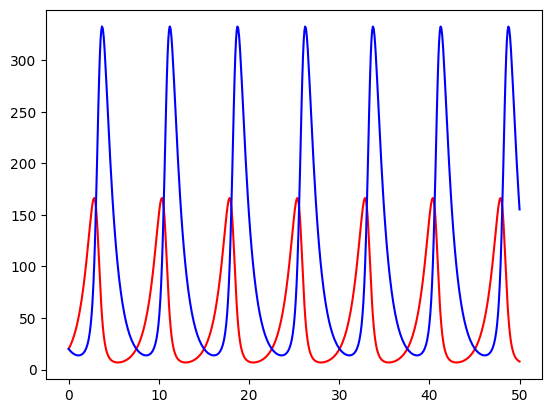

In [6]:
# Note if using this format, `dy` must be the first argument. Additionally, a special flag must be set to True when calling pysolve_ivp, see below.
def cy_diffeq(dy, t, y):
    dy[0] = (1. - 0.01 * y[1]) * y[0]
    dy[1] = (0.02 * y[0] - 1.) * y[1]

# Since this is pure python we can njit it safely
from numba import njit
cy_diffeq = njit(cy_diffeq)
    
import numpy as np
from CyRK import pysolve_ivp

initial_conds = np.asarray((20., 20.), dtype=np.float64, order='C')
time_span = (0., 50.)
rtol = 1.0e-7
atol = 1.0e-8

result = \
    pysolve_ivp(cy_diffeq, time_span, initial_conds, method="RK45", rtol=rtol, atol=atol,
                # Note if you did build a differential equation that has `dy` as the first argument then you must pass the following flag as `True`.
                # You could easily pass the `diffeq_nb` example which returns dy. You would just set this flag to False (and experience a hit to your performance).
                pass_dy_as_arg=True)

print("Was Integration was successful?", result.success)
print(result.message)
print("Size of solution: ", result.size)
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(result.t, result.y[0], c='r')
ax.plot(result.t, result.y[1], c='b')
plt.show()

In [7]:
%timeit pysolve_ivp(cy_diffeq, time_span, initial_conds, method="RK45", rtol=rtol, atol=atol, pass_dy_as_arg=True)

1.19 ms ± 9.88 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## `cysolve_ivp` Example

In [8]:
import cython
%load_ext cython

In [ ]:
%%cython --force 
# distutils: language = c++
# cython: boundscheck=False, wraparound=False, nonecheck=False, cdivision=True, initializedcheck=False

import numpy as np
cimport numpy as np
np.import_array()

# Note the "distutils" and "cython" headers above are functional. They tell cython how to compile the code. In this case we want to use C++ and to turn off several safety checks (which improve performance).

# The cython diffeq is much less flexible than the others described above. It must follow this format, including the type information. 
# Currently, CyRK only allows additional arguments to be passed in as a double array pointer (they all must be of type double). Mixed type args will be explored in the future if there is demand for it (make a GitHub issue if you'd like to see this feature!).
# The "noexcept nogil" tells cython that the Python Global Interpretor Lock is not required, and that no exceptions should be raised by the code within this function (both improve performance).
# If you do need the gil for your differential equation then you must use the `cysolve_ivp_gil` function instead of `cysolve_ivp`

# Import the required functions from CyRK
from CyRK cimport cysolve_ivp, DiffeqFuncType, WrapCySolverResult, CySolveOutput, PreEvalFunc

# Note that currently you must provide the "char* args, PreEvalFunc pre_eval_func" as inputs even if they are unused.
# See "Advanced CySolver.md" in the documentation for information about these parameters.
cdef void cython_diffeq(double* dy, double t, double* y, char* args, PreEvalFunc pre_eval_func) noexcept nogil:
    
    # Unpack args
    # CySolver assumes an arbitrary data type for additional arguments. So we must cast them to the array of 
    # doubles that we want to use for this equation
    cdef double* args_as_dbls = <double*>args
    cdef double a = args_as_dbls[0]
    cdef double b = args_as_dbls[1]
    
    # Build Coeffs
    cdef double coeff_1 = (1. - a * y[1])
    cdef double coeff_2 = (b * y[0] - 1.)
    
    # Store results
    dy[0] = coeff_1 * y[0]
    dy[1] = coeff_2 * y[1]
    # We can also capture additional output with cysolve_ivp.
    dy[2] = coeff_1
    dy[3] = coeff_2

# Import the required functions from CyRK
from CyRK cimport cysolve_ivp, DiffeqFuncType, WrapCySolverResult, CySolveOutput

# Let's get the integration number for the RK45 method
from CyRK cimport RK45_METHOD_INT

# Now let's import cysolve_ivp and build a function that runs it. We will not make this function `cdef` like the diffeq was. That way we can run it from python (this is not a requirement. If you want you can do everything within Cython).
# Since this function is not `cdef` we can use Python types for its input. We just need to clean them up and convert them to pure C before we call cysolve_ivp.
def run_cysolver(tuple t_span, double[::1] y0):
    
    # Cast our diffeq to the accepted format
    cdef DiffeqFuncType diffeq = cython_diffeq
    
    # Convert the python user input to pure C types
    cdef double* y0_ptr       = &y0[0]
    cdef unsigned int num_y   = len(y0)
    cdef double[2] t_span_arr = [t_span[0], t_span[1]]
    cdef double* t_span_ptr   = &t_span_arr[0]

    # Assume constant args
    cdef double[2] args       = [0.01, 0.02]
    cdef size_t size_of_args  = sizeof(args)
    cdef double* args_dbl_ptr = &args[0]
    # Need to recast the arg double pointer to a generic memory holder. CyRK uses char pointers for this purpose.
    cdef char* args_ptr = <char*>args_dbl_ptr

    # Run the integrator!
    cdef CySolveOutput result = cysolve_ivp(
        diffeq,
        t_span_ptr,
        y0_ptr,
        num_y,
        method = RK45_METHOD_INT, # Integration method
        rtol = 1.0e-7,
        atol = 1.0e-8,
        args_ptr = args_ptr,
        size_of_args = size_of_args,
        num_extra = 2
    )

    # The CySolveOutput is not accesible via Python. We need to wrap it first
    cdef WrapCySolverResult pysafe_result = WrapCySolverResult()
    pysafe_result.set_cyresult_pointer(result)

    return pysafe_result


In [10]:
# Assume we are working in a Jupyter notebook so we don't need to import `run_cysolver` if it was defined in an earlier cell.
# from my_cython_code import run_cysolver

import numpy as np
initial_conds = np.asarray((20., 20.), dtype=np.float64, order='C')
time_span = (0., 50.)

result = run_cysolver(time_span, initial_conds)

print("Was Integration was successful?", result.success)
print(result.message)
print("Size of solution: ", result.size)
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(result.t, result.y[0], c='r')
ax.plot(result.t, result.y[1], c='b')

# Can also plot the extra output. They are small for this example so scaling them up by 100
ax.plot(result.t, 100*result.y[2], c='green', ls=':')
ax.plot(result.t, 100*result.y[3], c='purple', ls=':')
plt.show()

NameError: name 'run_cysolver' is not defined

In [ ]:
%timeit run_cysolver(time_span, initial_conds)

## `t_eval` and dense output example
Read more about `t_eval` and dense output in "Documentation/Dense Output and t_eval.md"

In [ ]:
def cy_diffeq(dy, t, y):
    dy[0] = (1. - 0.01 * y[1]) * y[0]
    dy[1] = (0.02 * y[0] - 1.) * y[1]

from numba import njit
cy_diffeq = njit(cy_diffeq)
    
import numpy as np
from CyRK import pysolve_ivp

initial_conds = np.asarray((20., 20.), dtype=np.float64, order='C')
time_span = (0., 50.)
rtol = 1.0e-4
atol = 1.0e-5

result_normal = \
    pysolve_ivp(cy_diffeq, time_span, initial_conds, method="DOP853", rtol=rtol, atol=atol,
                pass_dy_as_arg=True)

print('Regular Shape: ', result_normal.y.shape)

# Use t_eval to provide more data points than the integrator used
t_eval = np.linspace(0., 50.0, 500)
result_t_eval = \
    pysolve_ivp(cy_diffeq, time_span, initial_conds, method="RK45", rtol=rtol, atol=atol,
                t_eval=t_eval,
                pass_dy_as_arg=True)

print('t_eval Shape: ', result_t_eval.y.shape)

# Or we could get the dense output and treat the result as a function
result_dense = \
    pysolve_ivp(cy_diffeq, time_span, initial_conds, method="RK45", rtol=rtol, atol=atol,
                dense_output=True,
                pass_dy_as_arg=True)

t_dense = np.linspace(3.0, 12.0, 250)
y_dense = result_dense(t_dense)
print('Dense Shape: ', y_dense.shape)

import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=3, figsize=(10., 4.0))
axes[0].plot(result_normal.t, result_normal.y[0], c='r')
axes[0].plot(result_normal.t, result_normal.y[1], c='b')
axes[0].set(title='Normal')

axes[1].plot(result_t_eval.t, result_t_eval.y[0], c='r')
axes[1].plot(result_t_eval.t, result_t_eval.y[1], c='b')
axes[1].set(title='t_eval')

axes[2].plot(t_dense, y_dense[0], c='r')
axes[2].plot(t_dense, y_dense[1], c='b')
axes[2].set(title='Dense Output')

plt.show()

## Backward Integration

In [ ]:
def diffeq(t, y):
    dy = np.empty_like(y)
    dy[0] = (1. - 0.01 * y[1]) * y[0]
    dy[1] = (0.02 * y[0] - 1.) * y[1]
    return dy

import numpy as np
from scipy.integrate import solve_ivp

initial_conds = np.asarray((70, 64.), dtype=np.float64, order='C')
# time_span = (0., 50.)
time_span = (50., 0.)
rtol = 1.0e-6
atol = 1.0e-8

t_eval = None
# t_eval = np.linspace(0.0, 50.0, 30)
# t_eval = np.linspace(50.0, 0.0, 30)


result = \
    solve_ivp(diffeq, time_span, initial_conds, method='RK45', rtol=rtol, atol=atol, t_eval=t_eval)

print("Was Integration was successful?", result.success)
print(result.message)
print("solve_ivp shape:", result.y.shape)
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(result.t, result.y[0], c='r')
ax.plot(result.t, result.y[1], c='b')
ax.set(title='solve_ivp')
plt.show()


from CyRK import pysolve_ivp
result_cy = \
    pysolve_ivp(diffeq, time_span, initial_conds, method='RK45', rtol=rtol, atol=atol, t_eval=t_eval)

print("Was Integration was successful?", result.success)
print(result.message)
print("pysolve_ivp shape:", result_cy.y.shape)
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(result_cy.t, result_cy.y[0], c='r')
ax.plot(result_cy.t, result_cy.y[1], c='b')
ax.set(title='pysolve_ivp')
plt.show()


## Backward Integration (with Dense)

In [ ]:
def diffeq(t, y):
    dy = np.empty_like(y)
    dy[0] = (1. - 0.01 * y[1]) * y[0]
    dy[1] = (0.02 * y[0] - 1.) * y[1]
    return dy

import numpy as np
from scipy.integrate import solve_ivp

initial_conds = np.asarray((70, 64.), dtype=np.float64, order='C')
time_span = (0., 50.)
# time_span = (50., 0.)
rtol = 1.0e-6
atol = 1.0e-8


t_eval = np.linspace(0.0, 50.0, 30)
# t_eval = np.linspace(50.0, 0.0, 30)

result = \
    solve_ivp(diffeq, time_span, initial_conds, method='RK45', rtol=rtol, atol=atol, dense_output=True)

print("Was Integration was successful?", result.success)
print(result.message)
print("solve_ivp shape:", result.y.shape)
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
sci_dense = result.sol(t_eval)
ax.plot(t_eval, sci_dense[0], c='r')
ax.plot(t_eval, sci_dense[1], c='b')
ax.set(title='solve_ivp')
plt.show()


from CyRK import pysolve_ivp
result_cy = \
    pysolve_ivp(diffeq, time_span, initial_conds, method='RK45', rtol=rtol, atol=atol, dense_output=True)

print("Was Integration was successful?", result.success)
print(result.message)
print("pysolve_ivp shape:", result_cy.y.shape)
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
pysolve_dense = result_cy(t_eval)
ax.plot(t_eval, pysolve_dense[0], c='r')
ax.plot(t_eval, pysolve_dense[1], c='b')
ax.set(title='pysolve_ivp')
plt.show()

print(np.allclose(pysolve_dense, sci_dense))
